In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from unyt import yr, Myr, kpc, arcsec, nJy, Mpc, Msun, erg, s, Hz, kelvin,angstrom
import h5py

from synthesizer.grid import Grid
from synthesizer.load_data.load_camels import load_CAMELS_Simba
from synthesizer.sed import Sed
from synthesizer.filters import Filter, FilterCollection
from synthesizer.sed import combine_list_of_seds
from synthesizer.emission_models import (
    IncidentEmission,
)

from synthesizer.conversions import lnu_to_absolute_mag, fnu_to_apparent_mag, fnu_to_lnu

/tmp/ipykernel_1640/424231431.py:10: FutureWarning: The filters module has been moved to the instruments module. Please update your imports synthesizer.filters -> synthesizer.instruments
  from synthesizer.filters import Filter, FilterCollection


In [2]:
# Alternative method for LF:
# try this method again, but using AB mag instead of mass, and suply your own bins (up to -17, say)
def calc_df(ab_mag, volume, massBinLimits):

# OG:        hist, dummy = np.histogram(np.log10(mstar), bins = massBinLimits)
        hist, dummy = np.histogram(ab_mag, bins = massBinLimits)
        hist = np.float64(hist)
        phi = (hist / volume) / (massBinLimits[1] - massBinLimits[0])

        phi_sigma = (np.sqrt(hist) / volume) /\
                    (massBinLimits[1] - massBinLimits[0]) # Poisson errors

        return phi, phi_sigma, hist

massBinLimits = np.arange(-22, -16, 0.5)


In [3]:
# get grid for all galaxies
# gives grid of metalicity and age which is used to map on our camels galaxies
grid_name = "bc03_chabrier03-0.1,100.hdf5"
#grid_name = "bc03-2016-Miles_chabrier-0.1,100.hdf5" # try old grid, LF looks weird?!
grid_dir = "/home/jovyan/"
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)

In [4]:
AGN1_df = pd.DataFrame()


In [5]:
# 1P set:
P1_X = '1P_p4_n2'# = 0.25

dir_ = '/home/jovyan/Data/Sims/SIMBA/1P/' + P1_X
gals_074 = load_CAMELS_Simba(
    dir_,
    snap_name='snapshot_074.hdf5', 
    group_name='groups_074.hdf5',
)


print('Number of Galaxies in snap_074', len(gals_074))

cat_074 = dir_+'/groups_074.hdf5'
# open file
f = h5py.File(cat_074, 'r')

# read different attributes of the header
boxSize_074 = f['Header'].attrs[u'BoxSize']/1e3 #Mpc/h
redshift_074 = f['Header'].attrs[u'Redshift']
print('BoxSize: ', boxSize_074)
print('redshift: ', redshift_074)

gals_074 = [gal for gal in gals_074 if len(gal.stars.ages) >= 100]  # this shouldnt be here?! donesnt make sense
gals_074 = [gal for gal in gals_074 if gal.stars.nstars >= 100]
gals_074 = [gal for gal in gals_074 if gal.gas.nparticles >= 100]

incident = IncidentEmission(grid)
little_h =  0.6711

spec_list = []
# Lets work with z=0 so gals_025
for i in gals_074:
    gal = i
    # get_spectra_incident An Sed object containing the stellar spectra
    spec = gal.stars.get_spectra(incident)
    spec.get_fnu0()
    spec_list.append(spec)

# combine
seds = combine_list_of_seds(spec_list)
seds.lnu  # get luminosity

# Need to use the grid lam, dont need to define wavelengths here: see codes here: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Swift/UVOT.UVM2&&mode=browse&gname=Swift&gname2=UVOT#filter
# need to use transmission NOT area
# Get for XMM
fil_uvm2_XMM = Filter("XMM/OM.UVM2_filter", new_lam=grid.lam)

# now get for UVOT
fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2_fil", new_lam=grid.lam) # changed from new_lam=lams_uvot to grid.lam and get 0 transmission, but warning sign is back

# what is a top hat filter?
filt1 = Filter("top_hat/filter.1", lam_min=1400*angstrom, lam_max=1600*angstrom, new_lam=grid.lam)

# 0 = TopHat, 1 = XMM, 2= Swift
filt_lst = [filt1, fil_uvm2_XMM, fil_uvm2_UVOT]

# get filters in combined array to apply to all galaxies
combined_filters = FilterCollection(
    filters=filt_lst, new_lam=grid.lam
)

seds.get_photo_lnu(combined_filters, verbose=True) 
seds.photo_lnu
phot = seds.get_photo_lnu(combined_filters, verbose=True) 
print(phot)

abs_mags = [lnu_to_absolute_mag(phot[f]) for f in combined_filters.filters]
abs_mag_th = abs_mags[0]

# next steps, get luminosity function for these magnitudes
# co-moving volume: BoxSize_025 and redshift:
little_h =  0.6711
Vphys = (boxSize_074/little_h )**3
Vcom = Vphys * ((1+redshift_074)**3)
print(Vcom)

phi, phi_sigma, hist = calc_df(abs_mag_th, Vcom, massBinLimits)

df = pd.DataFrame({
    'phi': phi,
    'phi_sigma': phi_sigma,
    'hist': hist
})
df['AGN1'] = 0.25
print(df)

# add to total DF for all AGN1 data
AGN1_df = pd.concat([AGN1_df, df], ignore_index=True)


/srv/conda/envs/notebook/lib/python3.9/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


Number of Galaxies in snap_074 16813
BoxSize:  25.0
redshift:  0.4658364469731915
--------------------------------------------------------------
|                  PHOTOMETRY (LUMINOSITY)                   |
|--------------------------------------|---------------------|
|  top_hat/filter.1 (λ = 1.50e+03 Å)   | 2.29e+31 erg/(Hz*s) |
|--------------------------------------|---------------------|
| XMM/OM.UVM2_filter (λ = 2.28e+03 Å)  | 2.22e+31 erg/(Hz*s) |
|--------------------------------------|---------------------|
| Swift/UVOT.UVM2_fil (λ = 2.25e+03 Å) | 2.23e+31 erg/(Hz*s) |
--------------------------------------------------------------

162822.66444696585
         phi  phi_sigma  hist  AGN1
0   0.000209   0.000051  17.0  0.25
1   0.000332   0.000064  27.0  0.25
2   0.000368   0.000067  30.0  0.25
3   0.000418   0.000072  34.0  0.25
4   0.000504   0.000079  41.0  0.25
5   0.000332   0.000064  27.0  0.25
6   0.000344   0.000065  28.0  0.25
7   0.000270   0.000058  22.0  0.25
8   0.0

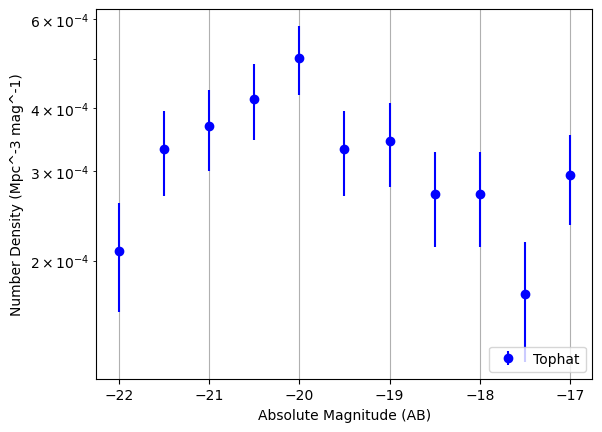

In [6]:

label_025 = 'z = ', redshift_074
label_th = 'Tophat'

# Plot the luminosity function
plt.errorbar(massBinLimits[:-1], phi, yerr=phi_sigma, fmt='o', color='blue', label=label_th)

plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')
plt.legend(loc='lower right')


#plt.title('Luminosity Function Top Hat filter')
plt.grid(True)
plt.show()

In [7]:


# 1P set:
P1_X = '1P_p4_n1'# = 0.5


dir_ = '/home/jovyan/Data/Sims/SIMBA/1P/' + P1_X
gals_074 = load_CAMELS_Simba(
    dir_,
    snap_name='snapshot_074.hdf5', 
    group_name='groups_074.hdf5',
)


print('Number of Galaxies in snap_074', len(gals_074))

cat_074 = dir_+'/groups_074.hdf5'
# open file
f = h5py.File(cat_074, 'r')

# read different attributes of the header
boxSize_074 = f['Header'].attrs[u'BoxSize']/1e3 #Mpc/h
redshift_074 = f['Header'].attrs[u'Redshift']
print('BoxSize: ', boxSize_074)
print('redshift: ', redshift_074)

gals_074 = [gal for gal in gals_074 if len(gal.stars.ages) >= 100]  # this shouldnt be here?! donesnt make sense
gals_074 = [gal for gal in gals_074 if gal.stars.nstars >= 100]
gals_074 = [gal for gal in gals_074 if gal.gas.nparticles >= 100]

incident = IncidentEmission(grid)
little_h =  0.6711

spec_list = []
# Lets work with z=0 so gals_025
for i in gals_074:
    gal = i
    # get_spectra_incident An Sed object containing the stellar spectra
    spec = gal.stars.get_spectra(incident)
    spec.get_fnu0()
    spec_list.append(spec)

# combine
seds = combine_list_of_seds(spec_list)
seds.lnu  # get luminosity

# Need to use the grid lam, dont need to define wavelengths here: see codes here: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Swift/UVOT.UVM2&&mode=browse&gname=Swift&gname2=UVOT#filter
# need to use transmission NOT area
# Get for XMM
fil_uvm2_XMM = Filter("XMM/OM.UVM2_filter", new_lam=grid.lam)

# now get for UVOT
fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2_fil", new_lam=grid.lam) # changed from new_lam=lams_uvot to grid.lam and get 0 transmission, but warning sign is back

# what is a top hat filter?
filt1 = Filter("top_hat/filter.1", lam_min=1400*angstrom, lam_max=1600*angstrom, new_lam=grid.lam)

# 0 = TopHat, 1 = XMM, 2= Swift
filt_lst = [filt1, fil_uvm2_XMM, fil_uvm2_UVOT]

# get filters in combined array to apply to all galaxies
combined_filters = FilterCollection(
    filters=filt_lst, new_lam=grid.lam
)

seds.get_photo_lnu(combined_filters, verbose=True) 

print(seds.get_photo_lnu(combined_filters, verbose=True))
seds.photo_lnu
phot = seds.get_photo_lnu(combined_filters, verbose=True) 
print(phot)

abs_mags = [lnu_to_absolute_mag(phot[f]) for f in combined_filters.filters]
abs_mag_th = abs_mags[0]

# next steps, get luminosity function for these magnitudes
# co-moving volume: BoxSize_025 and redshift:
little_h =  0.6711
Vphys = (boxSize_074/little_h )**3
Vcom = Vphys * ((1+redshift_074)**3)
print(Vcom)

phi, phi_sigma, hist = calc_df(abs_mag_th, Vcom, massBinLimits)

df = pd.DataFrame({
    'phi': phi,
    'phi_sigma': phi_sigma,
    'hist': hist
})
df['AGN1'] = 0.5

print(df)

# add to total DF for all AGN1 data
AGN1_df = pd.concat([AGN1_df, df], ignore_index=True)


/srv/conda/envs/notebook/lib/python3.9/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


Number of Galaxies in snap_074 18088
BoxSize:  25.0
redshift:  0.4658364469731915
--------------------------------------------------------------
|                  PHOTOMETRY (LUMINOSITY)                   |
|--------------------------------------|---------------------|
|  top_hat/filter.1 (λ = 1.50e+03 Å)   | 2.04e+31 erg/(Hz*s) |
|--------------------------------------|---------------------|
| XMM/OM.UVM2_filter (λ = 2.28e+03 Å)  | 1.96e+31 erg/(Hz*s) |
|--------------------------------------|---------------------|
| Swift/UVOT.UVM2_fil (λ = 2.25e+03 Å) | 1.97e+31 erg/(Hz*s) |
--------------------------------------------------------------

--------------------------------------------------------------
|                  PHOTOMETRY (LUMINOSITY)                   |
|--------------------------------------|---------------------|
|  top_hat/filter.1 (λ = 1.50e+03 Å)   | 2.04e+31 erg/(Hz*s) |
|--------------------------------------|---------------------|
| XMM/OM.UVM2_filter (λ = 2.28e+03 

In [8]:

# 1P set:
P1_X = '1P_p4_0'# = 1.0

dir_ = '/home/jovyan/Data/Sims/SIMBA/1P/' + P1_X
gals_074 = load_CAMELS_Simba(
    dir_,
    snap_name='snapshot_074.hdf5', 
    group_name='groups_074.hdf5',
)


print('Number of Galaxies in snap_074', len(gals_074))

cat_074 = dir_+'/groups_074.hdf5'
# open file
f = h5py.File(cat_074, 'r')

# read different attributes of the header
boxSize_074 = f['Header'].attrs[u'BoxSize']/1e3 #Mpc/h
redshift_074 = f['Header'].attrs[u'Redshift']
print('BoxSize: ', boxSize_074)
print('redshift: ', redshift_074)

gals_074 = [gal for gal in gals_074 if len(gal.stars.ages) >= 100]  # this shouldnt be here?! donesnt make sense
gals_074 = [gal for gal in gals_074 if gal.stars.nstars >= 100]
gals_074 = [gal for gal in gals_074 if gal.gas.nparticles >= 100]

incident = IncidentEmission(grid)
little_h =  0.6711

spec_list = []
# Lets work with z=0 so gals_025
for i in gals_074:
    gal = i
    # get_spectra_incident An Sed object containing the stellar spectra
    spec = gal.stars.get_spectra(incident)
    spec.get_fnu0()
    spec_list.append(spec)

# combine
seds = combine_list_of_seds(spec_list)
seds.lnu  # get luminosity

# Need to use the grid lam, dont need to define wavelengths here: see codes here: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Swift/UVOT.UVM2&&mode=browse&gname=Swift&gname2=UVOT#filter
# need to use transmission NOT area
# Get for XMM
fil_uvm2_XMM = Filter("XMM/OM.UVM2_filter", new_lam=grid.lam)

# now get for UVOT
fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2_fil", new_lam=grid.lam) # changed from new_lam=lams_uvot to grid.lam and get 0 transmission, but warning sign is back

# what is a top hat filter?
filt1 = Filter("top_hat/filter.1", lam_min=1400*angstrom, lam_max=1600*angstrom, new_lam=grid.lam)

# 0 = TopHat, 1 = XMM, 2= Swift
filt_lst = [filt1, fil_uvm2_XMM, fil_uvm2_UVOT]

# get filters in combined array to apply to all galaxies
combined_filters = FilterCollection(
    filters=filt_lst, new_lam=grid.lam
)

seds.get_photo_lnu(combined_filters, verbose=True) 

print(seds.get_photo_lnu(combined_filters, verbose=True))
seds.photo_lnu
phot = seds.get_photo_lnu(combined_filters, verbose=True) 
print(phot)

abs_mags = [lnu_to_absolute_mag(phot[f]) for f in combined_filters.filters]
abs_mag_th = abs_mags[0]

# next steps, get luminosity function for these magnitudes
# co-moving volume: BoxSize_025 and redshift:
little_h =  0.6711
Vphys = (boxSize_074/little_h )**3
Vcom = Vphys * ((1+redshift_074)**3)
print(Vcom)

phi, phi_sigma, hist = calc_df(abs_mag_th, Vcom, massBinLimits)

df = pd.DataFrame({
    'phi': phi,
    'phi_sigma': phi_sigma,
    'hist': hist
})
df['AGN1'] = 1.0
print(df)

# add to total DF for all AGN1 data
AGN1_df = pd.concat([AGN1_df, df], ignore_index=True)


/srv/conda/envs/notebook/lib/python3.9/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


Number of Galaxies in snap_074 24695
BoxSize:  25.0
redshift:  0.4658364469731915
--------------------------------------------------------------
|                  PHOTOMETRY (LUMINOSITY)                   |
|--------------------------------------|---------------------|
|  top_hat/filter.1 (λ = 1.50e+03 Å)   | 1.54e+31 erg/(Hz*s) |
|--------------------------------------|---------------------|
| XMM/OM.UVM2_filter (λ = 2.28e+03 Å)  | 1.50e+31 erg/(Hz*s) |
|--------------------------------------|---------------------|
| Swift/UVOT.UVM2_fil (λ = 2.25e+03 Å) | 1.50e+31 erg/(Hz*s) |
--------------------------------------------------------------

--------------------------------------------------------------
|                  PHOTOMETRY (LUMINOSITY)                   |
|--------------------------------------|---------------------|
|  top_hat/filter.1 (λ = 1.50e+03 Å)   | 1.54e+31 erg/(Hz*s) |
|--------------------------------------|---------------------|
| XMM/OM.UVM2_filter (λ = 2.28e+03 

In [ ]:

# 1P set:
P1_X = '1P_p4_1'# = 2.0

dir_ = '/home/jovyan/Data/Sims/SIMBA/1P/' + P1_X
gals_074 = load_CAMELS_Simba(
    dir_,
    snap_name='snapshot_074.hdf5', 
    group_name='groups_074.hdf5',
)

print('Number of Galaxies in snap_074', len(gals_074))

cat_074 = dir_+'/groups_074.hdf5'
# open file
f = h5py.File(cat_074, 'r')

# read different attributes of the header
boxSize_074 = f['Header'].attrs[u'BoxSize']/1e3 #Mpc/h
redshift_074 = f['Header'].attrs[u'Redshift']
print('BoxSize: ', boxSize_074)
print('redshift: ', redshift_074)

gals_074 = [gal for gal in gals_074 if len(gal.stars.ages) >= 100]  # this shouldnt be here?! donesnt make sense
gals_074 = [gal for gal in gals_074 if gal.stars.nstars >= 100]
gals_074 = [gal for gal in gals_074 if gal.gas.nparticles >= 100]

incident = IncidentEmission(grid)
little_h =  0.6711

spec_list = []
# Lets work with z=0 so gals_025
for i in gals_074:
    gal = i
    # get_spectra_incident An Sed object containing the stellar spectra
    spec = gal.stars.get_spectra(incident)
    spec.get_fnu0()
    spec_list.append(spec)

# combine
seds = combine_list_of_seds(spec_list)
seds.lnu  # get luminosity

# Need to use the grid lam, dont need to define wavelengths here: see codes here: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Swift/UVOT.UVM2&&mode=browse&gname=Swift&gname2=UVOT#filter
# need to use transmission NOT area
# Get for XMM
fil_uvm2_XMM = Filter("XMM/OM.UVM2_filter", new_lam=grid.lam)

# now get for UVOT
fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2_fil", new_lam=grid.lam) # changed from new_lam=lams_uvot to grid.lam and get 0 transmission, but warning sign is back

# what is a top hat filter?
filt1 = Filter("top_hat/filter.1", lam_min=1400*angstrom, lam_max=1600*angstrom, new_lam=grid.lam)

# 0 = TopHat, 1 = XMM, 2= Swift
filt_lst = [filt1, fil_uvm2_XMM, fil_uvm2_UVOT]

# get filters in combined array to apply to all galaxies
combined_filters = FilterCollection(
    filters=filt_lst, new_lam=grid.lam
)

seds.get_photo_lnu(combined_filters, verbose=True) 

print(seds.get_photo_lnu(combined_filters, verbose=True))
seds.photo_lnu
phot = seds.get_photo_lnu(combined_filters, verbose=True) 
print(phot)

abs_mags = [lnu_to_absolute_mag(phot[f]) for f in combined_filters.filters]
abs_mag_th = abs_mags[0]

# next steps, get luminosity function for these magnitudes
# co-moving volume: BoxSize_025 and redshift:
little_h =  0.6711
Vphys = (boxSize_074/little_h )**3
Vcom = Vphys * ((1+redshift_074)**3)
print(Vcom)

phi, phi_sigma, hist = calc_df(abs_mag_th, Vcom, massBinLimits)

df = pd.DataFrame({
    'phi': phi,
    'phi_sigma': phi_sigma,
    'hist': hist
})
df['AGN1'] = 2.0
print(df)

# add to total DF for all AGN1 data
AGN1_df = pd.concat([AGN1_df, df], ignore_index=True)



/srv/conda/envs/notebook/lib/python3.9/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


Number of Galaxies in snap_074 17905
BoxSize:  25.0
redshift:  0.4658364469731915


In [10]:
 
# 1P set:
P1_X = '1P_p4_2'# = 4.0

dir_ = '/home/jovyan/Data/Sims/SIMBA/1P/' + P1_X
gals_074 = load_CAMELS_Simba(
    dir_,
    snap_name='snapshot_074.hdf5', 
    group_name='groups_074.hdf5',
)

print('Number of Galaxies in snap_074', len(gals_074))

cat_074 = dir_+'/groups_074.hdf5'
# open file
f = h5py.File(cat_074, 'r')

# read different attributes of the header
boxSize_074 = f['Header'].attrs[u'BoxSize']/1e3 #Mpc/h
redshift_074 = f['Header'].attrs[u'Redshift']
print('BoxSize: ', boxSize_074)
print('redshift: ', redshift_074)

gals_074 = [gal for gal in gals_074 if len(gal.stars.ages) >= 100]  # this shouldnt be here?! donesnt make sense
gals_074 = [gal for gal in gals_074 if gal.stars.nstars >= 100]
gals_074 = [gal for gal in gals_074 if gal.gas.nparticles >= 100]

incident = IncidentEmission(grid)
little_h =  0.6711

spec_list = []
# Lets work with z=0 so gals_025
for i in gals_074:
    gal = i
    # get_spectra_incident An Sed object containing the stellar spectra
    spec = gal.stars.get_spectra(incident)
    spec.get_fnu0()
    spec_list.append(spec)

# combine
seds = combine_list_of_seds(spec_list)
seds.lnu  # get luminosity

# Need to use the grid lam, dont need to define wavelengths here: see codes here: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Swift/UVOT.UVM2&&mode=browse&gname=Swift&gname2=UVOT#filter
# need to use transmission NOT area
# Get for XMM
fil_uvm2_XMM = Filter("XMM/OM.UVM2_filter", new_lam=grid.lam)

# now get for UVOT
fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2_fil", new_lam=grid.lam) # changed from new_lam=lams_uvot to grid.lam and get 0 transmission, but warning sign is back

# what is a top hat filter?
filt1 = Filter("top_hat/filter.1", lam_min=1400*angstrom, lam_max=1600*angstrom, new_lam=grid.lam)

# 0 = TopHat, 1 = XMM, 2= Swift
filt_lst = [filt1, fil_uvm2_XMM, fil_uvm2_UVOT]

# get filters in combined array to apply to all galaxies
combined_filters = FilterCollection(
    filters=filt_lst, new_lam=grid.lam
)

seds.get_photo_lnu(combined_filters, verbose=True) 

print(seds.get_photo_lnu(combined_filters, verbose=True))
seds.photo_lnu
phot = seds.get_photo_lnu(combined_filters, verbose=True) 
print(phot)

abs_mags = [lnu_to_absolute_mag(phot[f]) for f in combined_filters.filters]
abs_mag_th = abs_mags[0]

# next steps, get luminosity function for these magnitudes
# co-moving volume: BoxSize_025 and redshift:
little_h =  0.6711
Vphys = (boxSize_074/little_h )**3
Vcom = Vphys * ((1+redshift_074)**3)
print(Vcom)

phi, phi_sigma, hist = calc_df(abs_mag_th, Vcom, massBinLimits)

df = pd.DataFrame({
    'phi': phi,
    'phi_sigma': phi_sigma,
    'hist': hist
})
df['AGN1'] = 4.0
print(df)

# add to total DF for all AGN1 data
AGN1_df = pd.concat([AGN1_df, df], ignore_index=True)



Number of Galaxies in snap_074 21470
BoxSize:  25.0
redshift:  0.4658364469731915
--------------------------------------------------------------
|                  PHOTOMETRY (LUMINOSITY)                   |
|--------------------------------------|---------------------|
|  top_hat/filter.1 (λ = 1.50e+03 Å)   | 1.68e+31 erg/(Hz*s) |
|--------------------------------------|---------------------|
| XMM/OM.UVM2_filter (λ = 2.28e+03 Å)  | 1.61e+31 erg/(Hz*s) |
|--------------------------------------|---------------------|
| Swift/UVOT.UVM2_fil (λ = 2.25e+03 Å) | 1.61e+31 erg/(Hz*s) |
--------------------------------------------------------------

--------------------------------------------------------------
|                  PHOTOMETRY (LUMINOSITY)                   |
|--------------------------------------|---------------------|
|  top_hat/filter.1 (λ = 1.50e+03 Å)   | 1.68e+31 erg/(Hz*s) |
|--------------------------------------|---------------------|
| XMM/OM.UVM2_filter (λ = 2.28e+03 

In [11]:
# Save DataFrame as a .txt file
AGN1_df.to_csv('/home/jovyan/camels/1P_set/1P_outputs/Simba/LF_1P_p1_nX_AGN1_SIMBA.txt', sep='\t', index=False)


In [12]:
AGN1_df

,phi,phi_sigma,hist,AGN1
0,0.000209,0.000051,17.0,0.25
1,0.000332,0.000064,27.0,0.25
2,0.000368,0.000067,30.0,0.25
3,0.000418,0.000072,34.0,0.25
4,0.000504,0.000079,41.0,0.25
5,0.000332,0.000064,27.0,0.25
6,0.000344,0.000065,28.0,0.25
7,0.000270,0.000058,22.0,0.25
8,0.000270,0.000058,22.0,0.25
9,0.000172,0.000046,14.0,0.25


/tmp/ipykernel_1640/2990394441.py:54: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(M_range, phi_schechter_fit, 'k-', label='Fitted Schechter Model', linewidth=3, linestyle='--')


Fitted Schechter Parameters:
alpha = -1.205
M* = -23.877
phi* = 1.579e-04
(1e-06, 0.001)


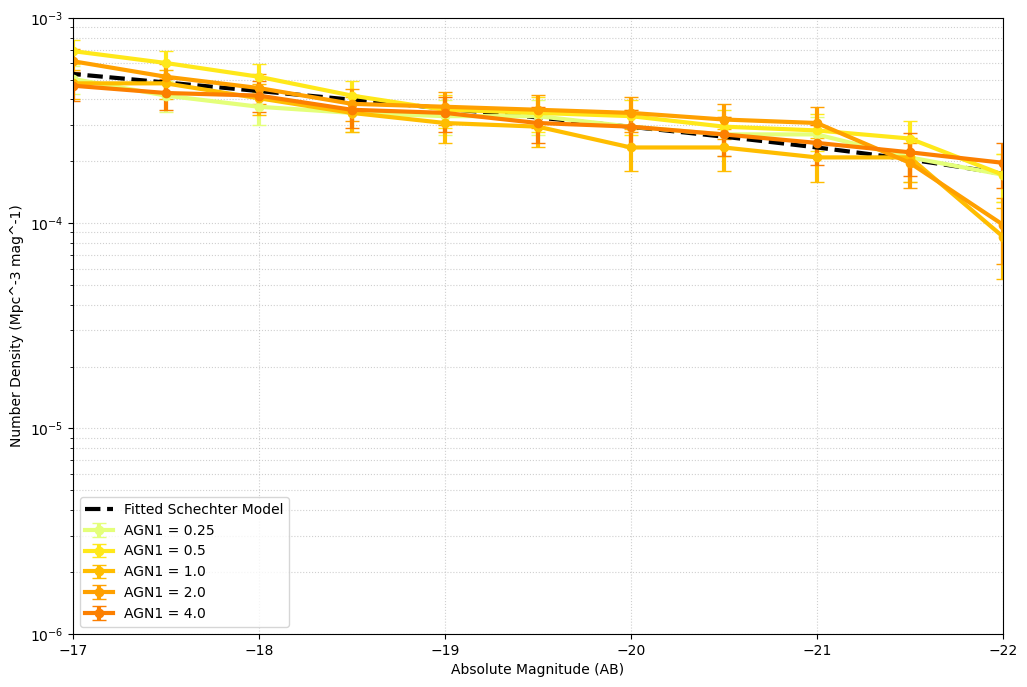

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma, gammaincc
from scipy.optimize import curve_fit

# Schechter function
def schechter(M, alpha, M_star, phi_star):
    return 0.4 * np.log(10) * phi_star * (10 ** (0.4 * (M_star - M))) ** (alpha + 1) * np.exp(-10 ** (0.4 * (M_star - M)))

# Define mass bin limits
massBinLimits = np.arange(-22, -16, 0.5)

# Assuming AGN1_df is your DataFrame with columns 'AGN1', 'phi', 'phi_sigma', and 'hist'
AGN1_values = AGN1_df['AGN1'].unique()

plt.figure(figsize=(12, 8))

colors = plt.cm.Wistia(np.linspace(0, 1, len(AGN1_values)))

# Prepare data for fitting
all_M = []
all_phi = []

for i, AGN1 in enumerate(AGN1_values):
    subset = AGN1_df[AGN1_df['AGN1'] == AGN1]
    subset = subset.sort_values('hist')
    
    plt.errorbar(massBinLimits[:-1], subset['phi'], yerr=subset['phi_sigma'], 
                 fmt='o-', color=colors[i], label=f'AGN1 = {AGN1}', 
                 capsize=5, markersize=6, linewidth=3.0)
    
    all_M.extend(massBinLimits[:-1])
    all_phi.extend(subset['phi'])

# Convert to numpy arrays
all_M = np.array(all_M)
all_phi = np.array(all_phi)

# Initial guess (Arnouts parameters)
initial_guess = [-1.55, -19.49, 1.69e-3]

# Fit the Schechter function to all data points
popt, _ = curve_fit(schechter, all_M, all_phi, p0=initial_guess)

# Extract fitted parameters
alpha_fit, M_star_fit, phi_star_fit = popt

# Calculate fitted Schechter function
M_range = np.linspace(min(all_M), max(all_M), 100)
phi_schechter_fit = schechter(M_range, *popt)

# Plot fitted Schechter function
plt.plot(M_range, phi_schechter_fit, 'k-', label='Fitted Schechter Model', linewidth=3, linestyle='--')

plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=10)
##plt.title('UV Luminosity Function with Fitted Schechter Model')
plt.grid(True, which='both', linestyle=':', alpha=0.6)

plt.xlim(-22, -17)
plt.ylim(1e-6, 1e-3)
plt.gca().invert_xaxis()
#plt.tight_layout()

# Print fitted parameters
print(f"Fitted Schechter Parameters:")
print(f"alpha = {alpha_fit:.3f}")
print(f"M* = {M_star_fit:.3f}")
print(f"phi* = {phi_star_fit:.3e}")

plt.savefig("/home/jovyan/camels/1P_set/1P_outputs/plots/UVLF_1P_AGN1_Simba.png", dpi=300, bbox_inches='tight')
print(plt.gca().get_ylim())

plt.show()


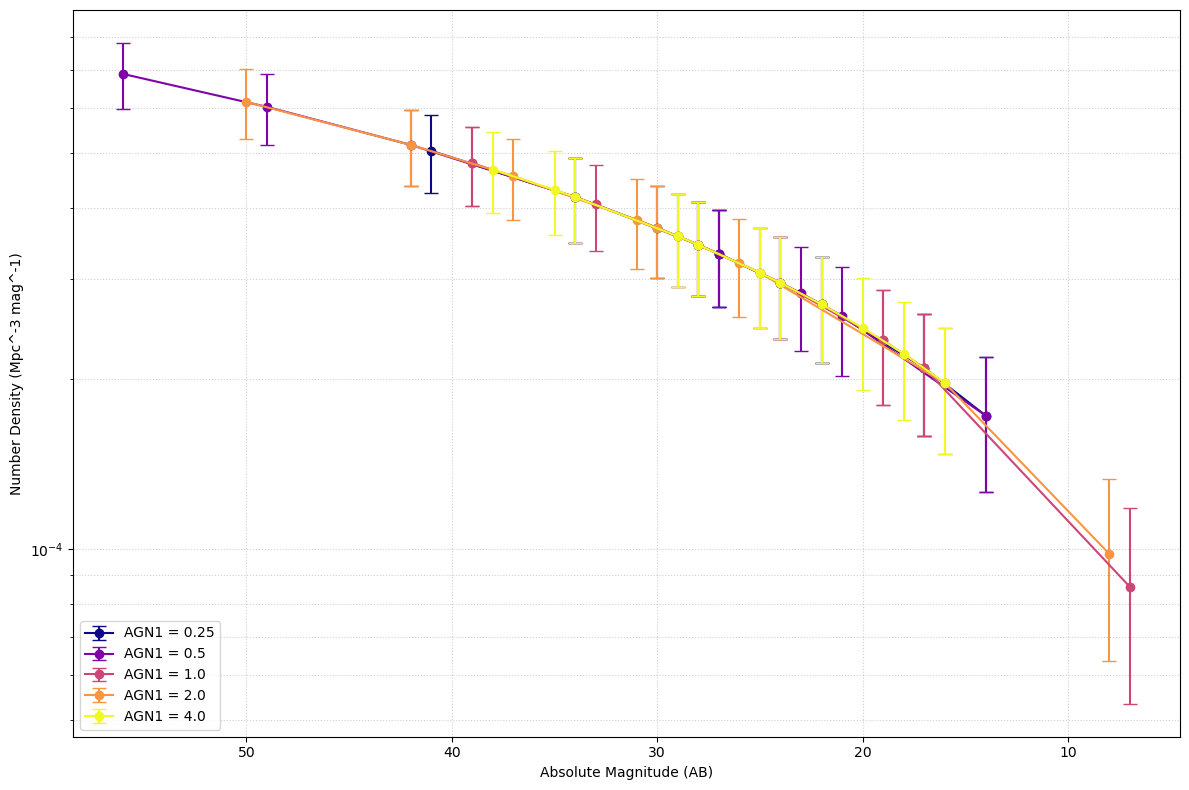

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame with columns 'AGN1', 'phi', 'phi_sigma', and 'hist'

# Create a list of unique AGN1 values
AGN1_values = AGN1_df['AGN1'].unique()

# Set up the plot
plt.figure(figsize=(12, 8))

# Define a color map for different AGN1 values
colors = plt.cm.plasma(np.linspace(0, 1, len(AGN1_values)))

# Plot the luminosity function for each AGN1 value
for i, AGN1 in enumerate(AGN1_values):
    subset = AGN1_df[AGN1_df['AGN1'] == AGN1]
    
    # Sort the subset by 'hist' to ensure correct x-axis ordering
    subset = subset.sort_values('hist')
    
    plt.errorbar(subset['hist'], subset['phi'], yerr=subset['phi_sigma'], 
                 fmt='o-', color=colors[i], label=f'AGN1 = {AGN1}', 
                 capsize=5, markersize=6)

plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=10)
##plt.title('UV Luminosity Function for Different AGN1 Values')
plt.grid(True, which='both', linestyle=':', alpha=0.6)

# Invert x-axis
plt.gca().invert_xaxis()

plt.tight_layout()
plt.show()

/tmp/ipykernel_1640/2259138182.py:54: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(M_range, phi_schechter_fit, 'k-', label='Fitted Schechter Model', linewidth=3, linestyle='--')


Fitted Schechter Parameters:
alpha = -1.205
M* = -23.877
phi* = 1.579e-04
(1e-06, 0.001)


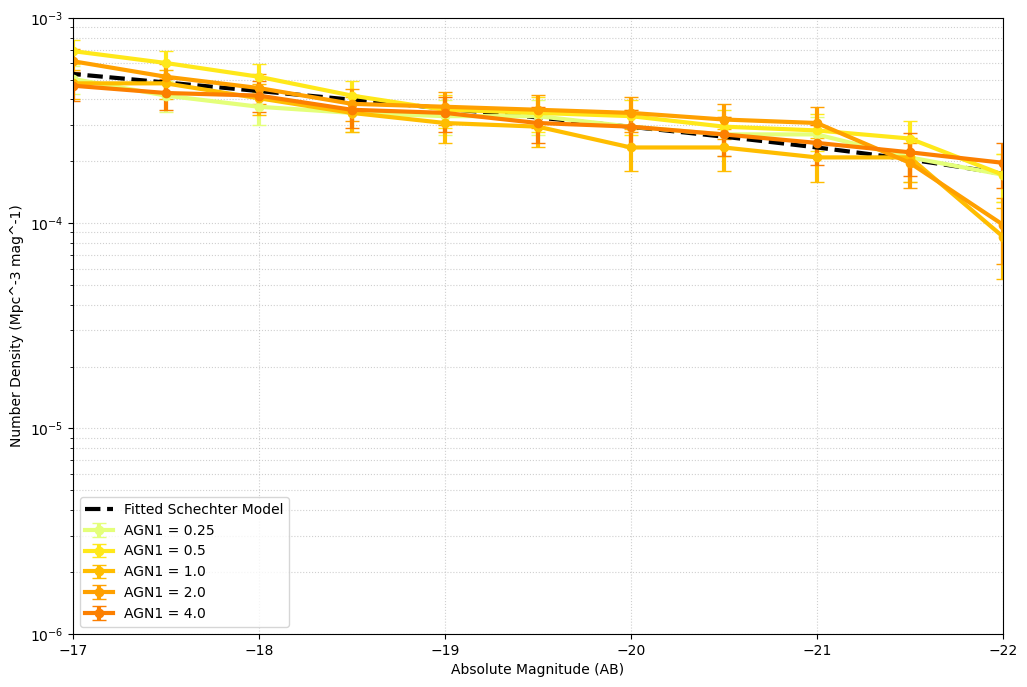

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma, gammaincc
from scipy.optimize import curve_fit

# Schechter function
def schechter(M, alpha, M_star, phi_star):
    return 0.4 * np.log(10) * phi_star * (10 ** (0.4 * (M_star - M))) ** (alpha + 1) * np.exp(-10 ** (0.4 * (M_star - M)))

# Define mass bin limits
massBinLimits = np.arange(-22, -16, 0.5)

# Assuming AGN1_df is your DataFrame with columns 'AGN1', 'phi', 'phi_sigma', and 'hist'
AGN1_values = AGN1_df['AGN1'].unique()

plt.figure(figsize=(12, 8))

colors = plt.cm.Wistia(np.linspace(0, 1, len(AGN1_values)))

# Prepare data for fitting
all_M = []
all_phi = []

for i, AGN1 in enumerate(AGN1_values):
    subset = AGN1_df[AGN1_df['AGN1'] == AGN1]
    subset = subset.sort_values('hist')
    
    plt.errorbar(massBinLimits[:-1], subset['phi'], yerr=subset['phi_sigma'], 
                 fmt='o-', color=colors[i], label=f'AGN1 = {AGN1}', 
                 capsize=5, markersize=6, linewidth=3.0)
    
    all_M.extend(massBinLimits[:-1])
    all_phi.extend(subset['phi'])

# Convert to numpy arrays
all_M = np.array(all_M)
all_phi = np.array(all_phi)

# Initial guess (Arnouts parameters)
initial_guess = [-1.55, -19.49, 1.69e-3]

# Fit the Schechter function to all data points
popt, _ = curve_fit(schechter, all_M, all_phi, p0=initial_guess)

# Extract fitted parameters
alpha_fit, M_star_fit, phi_star_fit = popt

# Calculate fitted Schechter function
M_range = np.linspace(min(all_M), max(all_M), 100)
phi_schechter_fit = schechter(M_range, *popt)

# Plot fitted Schechter function
plt.plot(M_range, phi_schechter_fit, 'k-', label='Fitted Schechter Model', linewidth=3, linestyle='--')

plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=10)
##plt.title('UV Luminosity Function with Fitted Schechter Model')
plt.grid(True, which='both', linestyle=':', alpha=0.6)

plt.xlim(-22, -17)
plt.ylim(1e-6, 1e-3)
plt.gca().invert_xaxis()
#plt.tight_layout()

# Print fitted parameters
print(f"Fitted Schechter Parameters:")
print(f"alpha = {alpha_fit:.3f}")
print(f"M* = {M_star_fit:.3f}")
print(f"phi* = {phi_star_fit:.3e}")

plt.savefig("/home/jovyan/camels/1P_set/1P_outputs/plots/UVLF_1P_AGN1_SIMBA.png", dpi=300, bbox_inches='tight')
print(plt.gca().get_ylim())

plt.show()


/tmp/ipykernel_1640/3790825865.py:60: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(M_range, phi_schechter_fit, 'k-', label='Fitted Schechter Model', linewidth=3, linestyle='--')
/tmp/ipykernel_1640/3790825865.py:63: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(M_range, phi_schechter_arnouts, 'r-', label='Arnouts Schechter Model', linewidth=3, linestyle='--')


Fitted Schechter Parameters:
alpha = -0.635
M* = -20.885
phi* = 1.036e-03

Arnouts Schechter Parameters:
alpha = -1.550
M* = -19.490
phi* = 1.690e-03


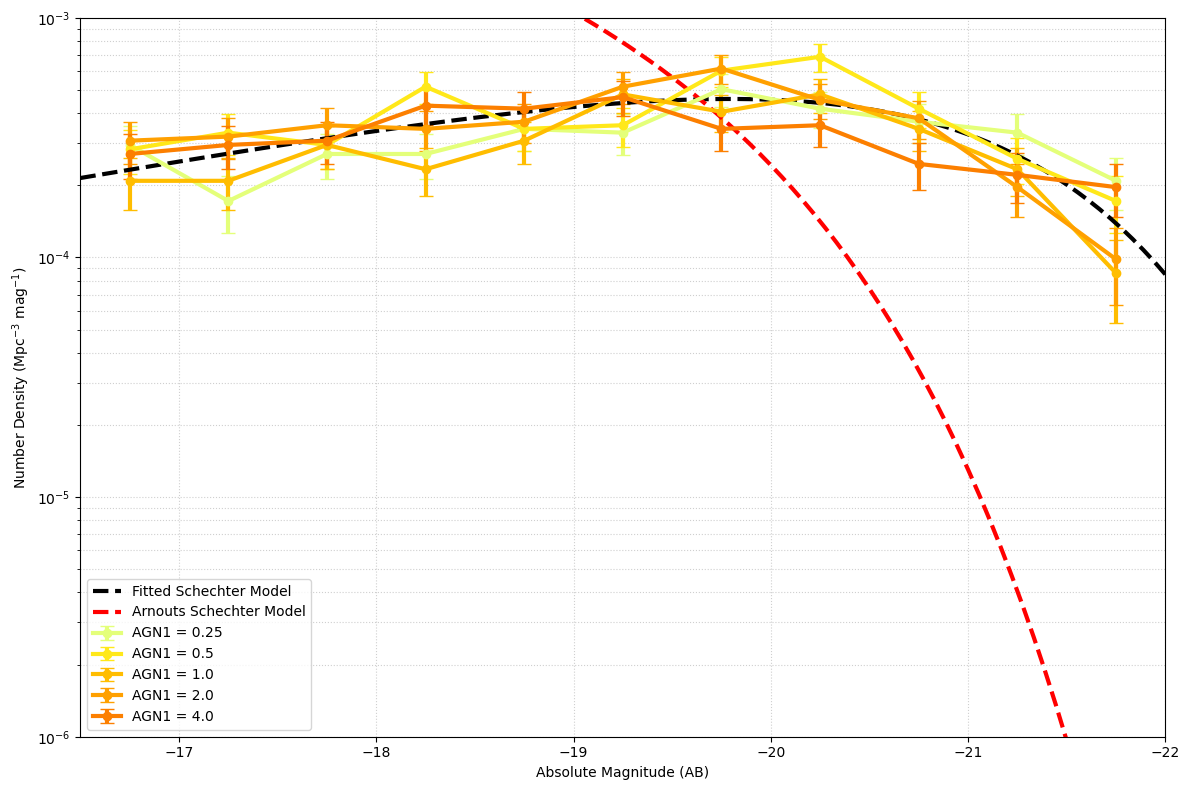

AGN1 = 0.25: 11 data points
AGN1 = 0.5: 11 data points
AGN1 = 1.0: 11 data points
AGN1 = 2.0: 11 data points
AGN1 = 4.0: 11 data points


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Schechter function
def schechter(M, alpha, M_star, phi_star):
    return 0.4 * np.log(10) * phi_star * (10 ** (0.4 * (M_star - M))) ** (alpha + 1) * np.exp(-10 ** (0.4 * (M_star - M)))

# Define mass bin limits
massBinLimits = np.arange(-22, -16, 0.5)
bin_centers = (massBinLimits[:-1] + massBinLimits[1:]) / 2

# Set up the plot
plt.figure(figsize=(12, 8))

# Define a color map for different AGN1 values
AGN1_values = AGN1_df['AGN1'].unique()
colors = plt.cm.Wistia(np.linspace(0, 1, len(AGN1_values)))

# Prepare data for fitting
all_M = []
all_phi = []

# Plot the luminosity function for each AGN1 value
for i, AGN1 in enumerate(AGN1_values):
    subset = AGN1_df[AGN1_df['AGN1'] == AGN1]
    
    # Ensure we have the correct number of points
    if len(subset) == len(bin_centers):
        plt.errorbar(bin_centers, subset['phi'], yerr=subset['phi_sigma'], 
                     fmt='o-', color=colors[i], label=f'AGN1 = {AGN1}', 
                     capsize=5, markersize=6, linewidth=3)
        all_M.extend(bin_centers)
        all_phi.extend(subset['phi'])
    else:
        print(f"Warning: Data length mismatch for AGN1 = {AGN1}. Expected {len(bin_centers)}, got {len(subset)}")

# Convert to numpy arrays
all_M = np.array(all_M)
all_phi = np.array(all_phi)

# Initial guess (Arnouts parameters)
initial_guess = [-1.55, -19.49, 1.69e-3]

# Fit Schechter function
popt, _ = curve_fit(schechter, all_M, all_phi, p0=initial_guess)

# Extract fitted parameters
alpha_fit, M_star_fit, phi_star_fit = popt

# Calculate fitted Schechter function
M_range = np.linspace(min(massBinLimits), max(massBinLimits), 100)
phi_schechter_fit = schechter(M_range, *popt)

# Calculate Arnouts Schechter function
phi_schechter_arnouts = schechter(M_range, *initial_guess)

# Plot fitted Schechter function
plt.plot(M_range, phi_schechter_fit, 'k-', label='Fitted Schechter Model', linewidth=3, linestyle='--')

# Plot Arnouts Schechter function
plt.plot(M_range, phi_schechter_arnouts, 'r-', label='Arnouts Schechter Model', linewidth=3, linestyle='--')

plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc$^{-3}$ mag$^{-1}$)')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=10)
#plt.title('UV Luminosity Function for Different AGN1 Values with Schechter Models')
plt.grid(True, which='both', linestyle=':', alpha=0.6)

# Set x-axis limits and invert
plt.xlim(max(massBinLimits), min(massBinLimits))  # Invert x-axis
plt.ylim(1e-6, 1e-3)
plt.tight_layout()

# Print fitted parameters
print(f"Fitted Schechter Parameters:")
print(f"alpha = {alpha_fit:.3f}")
print(f"M* = {M_star_fit:.3f}")
print(f"phi* = {phi_star_fit:.3e}")

print(f"\nArnouts Schechter Parameters:")
print(f"alpha = {initial_guess[0]:.3f}")
print(f"M* = {initial_guess[1]:.3f}")
print(f"phi* = {initial_guess[2]:.3e}")

plt.savefig("/home/jovyan/camels/1P_set/1P_outputs/plots/UVLF_1P_AGN1_with_Arnouts_SIMBA.png", dpi=300, bbox_inches='tight')
plt.show()

# Print some information about the data
for AGN1 in AGN1_values:
    subset = AGN1_df[AGN1_df['AGN1'] == AGN1]
    print(f"AGN1 = {AGN1}: {len(subset)} data points")
